# A continuación vamos a obtener la probabilidad de que los clientes puedan continuar en una compañía telefónica a través de su consumo y su edad mediante predicción con machine learning

In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
from bs4 import BeautifulSoup
import requests
import time
import string
import html5lib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression 
from sklearn.feature_selection import chi2 
from scipy import stats
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import lxml
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn import metrics
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_predict

### Importo los datos con los que trabajaré

In [2]:
clientes_diciembre = pd.read_csv('Practica_evaluacion/diciembre/clientes_diciembre.csv', sep='|')
consumos_diciembre = pd.read_csv('Practica_evaluacion/diciembre/consumos_diciembre.csv', sep='|')
financiacion_diciembre = pd.read_csv('Practica_evaluacion/diciembre/financiacion_diciembre.csv', sep='|')
productos_diciembre = pd.read_csv('Practica_evaluacion/diciembre/productos_diciembre.csv', sep='|')

clientes_enero = pd.read_csv('Practica_evaluacion/enero/clientes_enero.csv', sep='|')
consumos_enero = pd.read_csv('Practica_evaluacion/enero/consumos_enero.csv', sep='|')
financiacion_enero = pd.read_csv('Practica_evaluacion/enero/financiacion_enero.csv', sep='|')
productos_enero = pd.read_csv('Practica_evaluacion/enero/productos_enero.csv', sep='|')

### Comienzo unificando los archivos para crear una única estructura con la cual trabajar.

In [3]:
clientes_diciembre.head()

,id,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia
0,1,63,216.028109,2018-11-23 08:48:00,La Rioja,5,NaN,NaN
1,2,84,255.830842,2017-08-22 03:19:00,Vizcaya,3,NaN,NaN
2,3,66,135.768153,2001-12-27 13:50:00,Albacete,4,NaN,NaN
3,4,69,255.658527,2015-08-08 10:53:00,Lugo,4,NaN,NaN
4,5,30,22.302845,1997-08-29 02:19:00,Tarragona,2,2.0,NaN


In [4]:
consumos_diciembre.head()

,id,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal
0,1,110,79,10897,12806,13751
1,2,189,89,18657,6499,10862
2,3,129,30,15511,17013,16743
3,4,51,52,12670,3393,6771
4,5,183,3,23756,18436,4485


In [5]:
consumos_diciembre.shape

(95467, 6)

In [6]:
sum(consumos_diciembre.id == clientes_diciembre.id)

95467

In [7]:
result = pd.merge(consumos_diciembre, clientes_diciembre, on="id")

In [8]:
result.head()

,id,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia
0,1,110,79,10897,12806,13751,63,216.028109,2018-11-23 08:48:00,La Rioja,5,NaN,NaN
1,2,189,89,18657,6499,10862,84,255.830842,2017-08-22 03:19:00,Vizcaya,3,NaN,NaN
2,3,129,30,15511,17013,16743,66,135.768153,2001-12-27 13:50:00,Albacete,4,NaN,NaN
3,4,51,52,12670,3393,6771,69,255.658527,2015-08-08 10:53:00,Lugo,4,NaN,NaN
4,5,183,3,23756,18436,4485,30,22.302845,1997-08-29 02:19:00,Tarragona,2,2.0,NaN


In [9]:
financiacion_diciembre.head()

,id,financiacion,imp_financ,descuentos
0,2,NaN,NaN,SI
1,3,NaN,NaN,SI
2,7,SI,31.553269,NaN
3,11,NaN,NaN,SI
4,12,NaN,NaN,SI


In [10]:
financiacion_diciembre.shape

(24198, 4)

In [11]:
productos_diciembre.head()

,id,conexion,vel_conexion,TV
0,1,FIBRA,50MB,tv-futbol
1,2,FIBRA,600MB,tv-futbol
2,3,ADSL,35MB,tv-futbol
3,4,FIBRA,200MB,tv-familiar
4,5,ADSL,10MB,tv-futbol


In [12]:
sum(clientes_diciembre.id == productos_diciembre.id)

95467

In [13]:
result = pd.merge(result, productos_diciembre, on="id")

In [14]:
result.shape

(95467, 16)

In [15]:
result = pd.merge(result, financiacion_diciembre, how='left', on="id")

In [16]:
result.shape

(95467, 19)

In [17]:
result.head()

,id,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,conexion,vel_conexion,TV,financiacion,imp_financ,descuentos
0,1,110,79,10897,12806,13751,63,216.028109,2018-11-23 08:48:00,La Rioja,5,NaN,NaN,FIBRA,50MB,tv-futbol,NaN,NaN,NaN
1,2,189,89,18657,6499,10862,84,255.830842,2017-08-22 03:19:00,Vizcaya,3,NaN,NaN,FIBRA,600MB,tv-futbol,NaN,NaN,SI
2,3,129,30,15511,17013,16743,66,135.768153,2001-12-27 13:50:00,Albacete,4,NaN,NaN,ADSL,35MB,tv-futbol,NaN,NaN,SI
3,4,51,52,12670,3393,6771,69,255.658527,2015-08-08 10:53:00,Lugo,4,NaN,NaN,FIBRA,200MB,tv-familiar,NaN,NaN,NaN
4,5,183,3,23756,18436,4485,30,22.302845,1997-08-29 02:19:00,Tarragona,2,2.0,NaN,ADSL,10MB,tv-futbol,NaN,NaN,NaN


In [18]:
clientes_enero.shape

(92711, 8)

In [19]:
result_enero = pd.merge(consumos_enero, clientes_enero, on="id")

In [20]:
result_enero = pd.merge(result_enero, productos_enero, on="id")

In [21]:
result_enero = pd.merge(result_enero, financiacion_enero, how='left', on="id")

In [22]:
result_enero.head()

,id,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,conexion,vel_conexion,TV,financiacion,imp_financ,descuentos
0,1,95,19,6525,7634,18520,63,216.028109,11/23/2018 08:48 AM,La Rioja,5,NaN,NaN,FIBRA,50MB,tv-futbol,NaN,NaN,NaN
1,2,44,36,14471,14541,8016,84,255.830842,08/22/2017 03:19 AM,Vizcaya,3,NaN,NaN,FIBRA,600MB,tv-futbol,NaN,NaN,SI
2,3,94,27,1428,5248,7106,66,135.768153,12/27/2001 01:50 PM,Albacete,4,NaN,NaN,ADSL,35MB,tv-futbol,NaN,NaN,SI
3,4,186,20,20083,7372,5052,69,255.658527,08/08/2015 10:53 AM,Lugo,4,NaN,NaN,FIBRA,200MB,tv-familiar,NaN,NaN,NaN
4,6,37,32,19078,5009,8686,51,99.348645,11/04/1997 11:43 AM,Huelva,4,NaN,NaN,FIBRA,200MB,tv-futbol,NaN,NaN,NaN


In [23]:
result.shape

(95467, 19)

In [24]:
result_enero.shape

(92711, 19)

### Cuento cuantos id del mes de diciembre se encuentran en el mes de enero

In [25]:
result.id.isin(result_enero.id).sum()

88382

In [26]:
target = result.id.isin(result_enero.id)

### Cuento la diferencia de id entre los meses

In [27]:
result.shape[0] - result.id.isin(result_enero.id).sum()

7085

### Creo mi variable target donde 1 es si continua y 0 es si no

In [28]:
target = target.apply(lambda x: 1 if (x == True) else 0)

In [29]:
result['target'] = target

In [30]:
result.head()

,id,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,conexion,vel_conexion,TV,financiacion,imp_financ,descuentos,target
0,1,110,79,10897,12806,13751,63,216.028109,2018-11-23 08:48:00,La Rioja,5,NaN,NaN,FIBRA,50MB,tv-futbol,NaN,NaN,NaN,1
1,2,189,89,18657,6499,10862,84,255.830842,2017-08-22 03:19:00,Vizcaya,3,NaN,NaN,FIBRA,600MB,tv-futbol,NaN,NaN,SI,1
2,3,129,30,15511,17013,16743,66,135.768153,2001-12-27 13:50:00,Albacete,4,NaN,NaN,ADSL,35MB,tv-futbol,NaN,NaN,SI,1
3,4,51,52,12670,3393,6771,69,255.658527,2015-08-08 10:53:00,Lugo,4,NaN,NaN,FIBRA,200MB,tv-familiar,NaN,NaN,NaN,1
4,5,183,3,23756,18436,4485,30,22.302845,1997-08-29 02:19:00,Tarragona,2,2.0,NaN,ADSL,10MB,tv-futbol,NaN,NaN,NaN,0


### Creo una columna con el mes para luego de unificados los dataframes poder separarlos en base a los meses

In [31]:
result['mes'] = 'Diciembre'
result.head()

,id,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,edad,facturacion,antiguedad,provincia,...,num_dt,incidencia,conexion,vel_conexion,TV,financiacion,imp_financ,descuentos,target,mes
0,1,110,79,10897,12806,13751,63,216.028109,2018-11-23 08:48:00,La Rioja,...,NaN,NaN,FIBRA,50MB,tv-futbol,NaN,NaN,NaN,1,Diciembre
1,2,189,89,18657,6499,10862,84,255.830842,2017-08-22 03:19:00,Vizcaya,...,NaN,NaN,FIBRA,600MB,tv-futbol,NaN,NaN,SI,1,Diciembre
2,3,129,30,15511,17013,16743,66,135.768153,2001-12-27 13:50:00,Albacete,...,NaN,NaN,ADSL,35MB,tv-futbol,NaN,NaN,SI,1,Diciembre
3,4,51,52,12670,3393,6771,69,255.658527,2015-08-08 10:53:00,Lugo,...,NaN,NaN,FIBRA,200MB,tv-familiar,NaN,NaN,NaN,1,Diciembre
4,5,183,3,23756,18436,4485,30,22.302845,1997-08-29 02:19:00,Tarragona,...,2.0,NaN,ADSL,10MB,tv-futbol,NaN,NaN,NaN,0,Diciembre


In [32]:
result_enero['mes'] = 'Enero'
result_enero.head()

,id,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,edad,facturacion,antiguedad,provincia,num_lineas,num_dt,incidencia,conexion,vel_conexion,TV,financiacion,imp_financ,descuentos,mes
0,1,95,19,6525,7634,18520,63,216.028109,11/23/2018 08:48 AM,La Rioja,5,NaN,NaN,FIBRA,50MB,tv-futbol,NaN,NaN,NaN,Enero
1,2,44,36,14471,14541,8016,84,255.830842,08/22/2017 03:19 AM,Vizcaya,3,NaN,NaN,FIBRA,600MB,tv-futbol,NaN,NaN,SI,Enero
2,3,94,27,1428,5248,7106,66,135.768153,12/27/2001 01:50 PM,Albacete,4,NaN,NaN,ADSL,35MB,tv-futbol,NaN,NaN,SI,Enero
3,4,186,20,20083,7372,5052,69,255.658527,08/08/2015 10:53 AM,Lugo,4,NaN,NaN,FIBRA,200MB,tv-familiar,NaN,NaN,NaN,Enero
4,6,37,32,19078,5009,8686,51,99.348645,11/04/1997 11:43 AM,Huelva,4,NaN,NaN,FIBRA,200MB,tv-futbol,NaN,NaN,NaN,Enero


### Concateno los dataframe para poder comenzar con la limpieza y creación de nuevas variables

In [33]:
total = pd.concat([result, result_enero], ignore_index=True, sort=False)

In [34]:
total.head()

,id,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,edad,facturacion,antiguedad,provincia,...,num_dt,incidencia,conexion,vel_conexion,TV,financiacion,imp_financ,descuentos,target,mes
0,1,110,79,10897,12806,13751,63,216.028109,2018-11-23 08:48:00,La Rioja,...,NaN,NaN,FIBRA,50MB,tv-futbol,NaN,NaN,NaN,1.0,Diciembre
1,2,189,89,18657,6499,10862,84,255.830842,2017-08-22 03:19:00,Vizcaya,...,NaN,NaN,FIBRA,600MB,tv-futbol,NaN,NaN,SI,1.0,Diciembre
2,3,129,30,15511,17013,16743,66,135.768153,2001-12-27 13:50:00,Albacete,...,NaN,NaN,ADSL,35MB,tv-futbol,NaN,NaN,SI,1.0,Diciembre
3,4,51,52,12670,3393,6771,69,255.658527,2015-08-08 10:53:00,Lugo,...,NaN,NaN,FIBRA,200MB,tv-familiar,NaN,NaN,NaN,1.0,Diciembre
4,5,183,3,23756,18436,4485,30,22.302845,1997-08-29 02:19:00,Tarragona,...,2.0,NaN,ADSL,10MB,tv-futbol,NaN,NaN,NaN,0.0,Diciembre


#### Comienzo haciendo WebScrasping de la página de wikipedia para obtener las comunidades autónomas y así poder crear una nueva columna donde agrupe las provincias en comunidades autónomas.

In [35]:
url = 'https://es.wikipedia.org/wiki/Comunidad_aut%C3%B3noma'
data = requests.get(url).text
soup = BeautifulSoup(data, 'html.parser')
table = soup.find_all('table')[2]
df1=pd.read_html(str(table))
df1=pd.DataFrame(df1[0])
comunidad_autonoma = df1[['Comunidadautónoma','Provincias']]
comunidad_autonoma.head()

,Comunidadautónoma,Provincias
0,Andalucía[6]​,Almería
1,Andalucía[6]​,Cádiz
2,Andalucía[6]​,Córdoba
3,Andalucía[6]​,Granada
4,Andalucía[6]​,Huelva


##### Me percato que en mi dataframe "total" las provincias de Murcia y de Baleares tienen los nombres distintos a los de wikipedia, por lo tanto los renombro de manera que queden iguales y así poder trabajar con ellos.

In [36]:
total.provincia.replace({'Murcia':'Región de Murcia','Islas Baleares':'Baleares'},inplace=True)

In [37]:
comunidad_autonoma_split = pd.DataFrame(comunidad_autonoma['Comunidadautónoma'].str.split('[',1).tolist(),
                                 columns = ['com_aut','eliminar'])

In [38]:
comunidad_autonoma['Comunidadautónoma'] = comunidad_autonoma_split['com_aut']

<ipython-input-38-78e7e30a3091>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comunidad_autonoma['Comunidadautónoma'] = comunidad_autonoma_split['com_aut']


##### Hago un merge en provincia para poder anexarle la nueva columna comunidadautonoma al dataframe total.

In [39]:
comunidad_autonoma.columns = ['comunidadautonoma', 'provincia']

In [40]:
total = pd.merge(total, comunidad_autonoma, how='left', on="provincia")

In [41]:
total.comunidadautonoma.unique()

array(['La Rioja', 'País Vasco', 'Castilla-La Mancha', 'Galicia',
       'Cataluña', 'Andalucía', 'Comunidad Valenciana',
       'Comunidad de Madrid', 'Canarias', 'Castilla y León', 'Aragón',
       'Comunidad Foral de Navarra', 'Extremadura',
       'Principado de Asturias', 'Islas Baleares', 'Cantabria',
       'Región de Murcia'], dtype=object)

##### Le agrego una columna de días de antiguedad partiendo de la columna antiguedad hasta la fecha

In [42]:
total['antiguedad'] = pd.to_datetime(total['antiguedad'])

In [43]:
total['antiguedad'] = total['antiguedad'].dt.date

In [44]:
fecha_de_corte = {
    'Diciembre' : '2019-12-31',
    'Enero' : '2020-01-31'
}
total['fecha_de_corte'] = total.mes.map(fecha_de_corte)

In [45]:
total.dtypes

id                     int64
num_llamad_ent         int64
num_llamad_sal         int64
mb_datos               int64
seg_llamad_ent         int64
seg_llamad_sal         int64
edad                   int64
facturacion          float64
antiguedad            object
provincia             object
num_lineas             int64
num_dt               float64
incidencia            object
conexion              object
vel_conexion          object
TV                    object
financiacion          object
imp_financ           float64
descuentos            object
target               float64
mes                   object
comunidadautonoma     object
fecha_de_corte        object
dtype: object

In [46]:
total['fecha_de_corte'] = pd.to_datetime(total['fecha_de_corte'])
total['antiguedad'] = pd.to_datetime(total['antiguedad'])

In [47]:
total['dias_antiguedad'] = total['fecha_de_corte'] - total['antiguedad']
total['dias_antiguedad'] = total.dias_antiguedad.dt.days

In [48]:
total.head()

,id,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,edad,facturacion,antiguedad,provincia,...,vel_conexion,TV,financiacion,imp_financ,descuentos,target,mes,comunidadautonoma,fecha_de_corte,dias_antiguedad
0,1,110,79,10897,12806,13751,63,216.028109,2018-11-23,La Rioja,...,50MB,tv-futbol,NaN,NaN,NaN,1.0,Diciembre,La Rioja,2019-12-31,403
1,2,189,89,18657,6499,10862,84,255.830842,2017-08-22,Vizcaya,...,600MB,tv-futbol,NaN,NaN,SI,1.0,Diciembre,País Vasco,2019-12-31,861
2,3,129,30,15511,17013,16743,66,135.768153,2001-12-27,Albacete,...,35MB,tv-futbol,NaN,NaN,SI,1.0,Diciembre,Castilla-La Mancha,2019-12-31,6578
3,4,51,52,12670,3393,6771,69,255.658527,2015-08-08,Lugo,...,200MB,tv-familiar,NaN,NaN,NaN,1.0,Diciembre,Galicia,2019-12-31,1606
4,5,183,3,23756,18436,4485,30,22.302845,1997-08-29,Tarragona,...,10MB,tv-futbol,NaN,NaN,NaN,0.0,Diciembre,Cataluña,2019-12-31,8159


##### Verifico si hay nulos en las columnas

In [49]:
total.isna().sum()

id                        0
num_llamad_ent            0
num_llamad_sal            0
mb_datos                  0
seg_llamad_ent            0
seg_llamad_sal            0
edad                      0
facturacion               0
antiguedad                0
provincia                 0
num_lineas                0
num_dt               180835
incidencia           182613
conexion                  2
vel_conexion              6
TV                        0
financiacion         175140
imp_financ           175140
descuentos           148986
target                92711
mes                       0
comunidadautonoma         0
fecha_de_corte            0
dias_antiguedad           0
dtype: int64

-----------------------

### Hago los reemplazos necesarios para convertir mis variables a numericas, y relleno, en los casos donde aplique, los null con la mediana de la variable. Todo esto con el fin de realizar un primer modelo y así tener una primera aproximación. 

In [50]:
total1 = total.copy()

In [51]:
total1.drop('antiguedad',axis=1,inplace=True)
total1.drop('fecha_de_corte',axis=1,inplace=True)
total1.drop('provincia',axis=1,inplace=True)

total1.num_dt.fillna(0, inplace = True)
total1.incidencia.fillna('NO', inplace = True)
total1.financiacion.fillna('NO', inplace = True)
total1.imp_financ.fillna(0, inplace = True)
total1.descuentos.fillna('NO', inplace = True)
total1.conexion.fillna('ADSL', inplace = True)
total1.vel_conexion.fillna('200MB', inplace = True)
total1.vel_conexion.replace({'?':'200MB','1':'200MB','16598':'200MB'},inplace=True)

total1.vel_conexion.replace({
    '200MB':9,
    '600MB':11,
    '300MB':10,
    '50MB':7,
    '100MB':8,
    '20MB':3,
    '25MB':4,
    '10MB':1,
    '30MB':5,
    '35MB':6,
    '15MB':2},
    inplace=True)

total1.comunidadautonoma.replace({
    'Castilla y León':1,
    'Andalucía':2,
    'Castilla-La Mancha':3,
    'Galicia':4,
    'Cataluña':5,
    'Comunidad Valenciana':6,
    'Aragón':7,
    'País Vasco':8,
    'Extremadura':9,
    'Canarias':10,
    'Comunidad Foral de Navarra':11,
    'Principado de Asturias':12,
    'Región de Murcia':13,
    'Islas Baleares':14,
    'Comunidad de Madrid':15,
    'La Rioja':16,
    'Cantabria':17},
    inplace=True)

total1.financiacion.replace(('NO','SI'),
                      (0,1),inplace=True)
total1.descuentos.replace(('NO','SI'),
                      (0,1),inplace=True)
total1.conexion.replace(('ADSL','FIBRA'),
                      (1,2),inplace=True)
total1.TV.replace(('tv-futbol','tv-familiar','tv-total'),
                      (1,2,3),inplace=True)
total1.incidencia.replace(('NO','SI'),
                      (0,1),inplace=True)

#### Vuelvo a verificar si hay nulos en las columnas

In [52]:
total1.isna().sum()

id                       0
num_llamad_ent           0
num_llamad_sal           0
mb_datos                 0
seg_llamad_ent           0
seg_llamad_sal           0
edad                     0
facturacion              0
num_lineas               0
num_dt                   0
incidencia               0
conexion                 0
vel_conexion             0
TV                       0
financiacion             0
imp_financ               0
descuentos               0
target               92711
mes                      0
comunidadautonoma        0
dias_antiguedad          0
dtype: int64

In [53]:
total1.dtypes

id                     int64
num_llamad_ent         int64
num_llamad_sal         int64
mb_datos               int64
seg_llamad_ent         int64
seg_llamad_sal         int64
edad                   int64
facturacion          float64
num_lineas             int64
num_dt               float64
incidencia             int64
conexion               int64
vel_conexion           int64
TV                     int64
financiacion           int64
imp_financ           float64
descuentos             int64
target               float64
mes                   object
comunidadautonoma      int64
dias_antiguedad        int64
dtype: object

#### Vemos como se comportan las variables

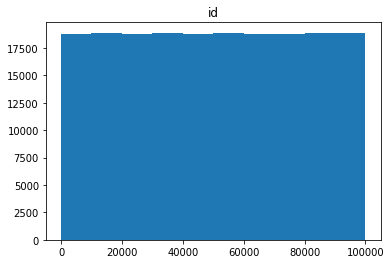

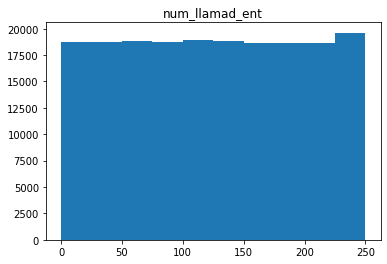

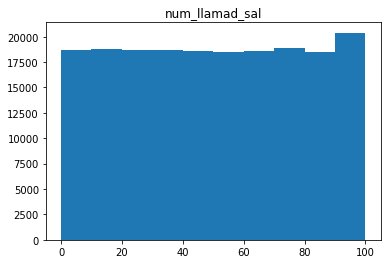

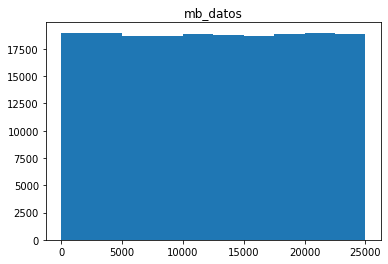

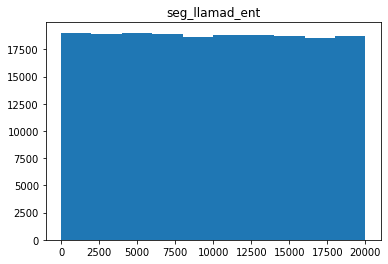

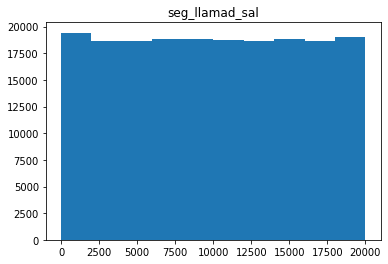

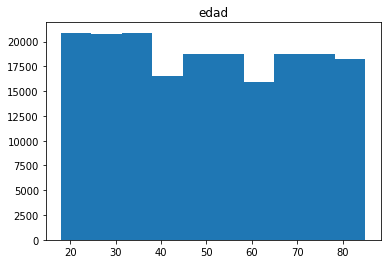

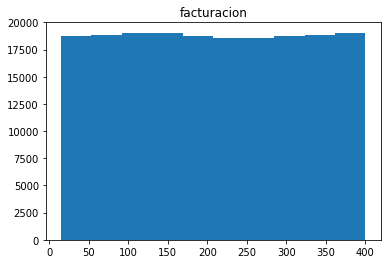

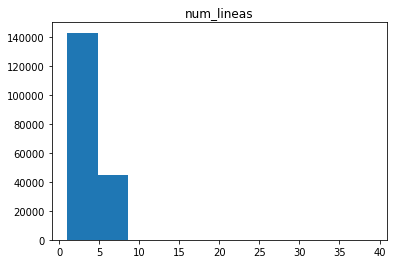

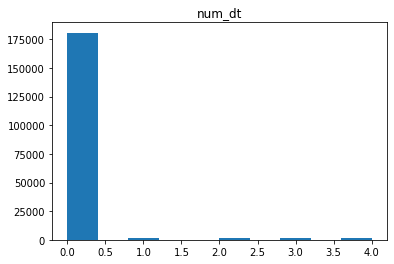

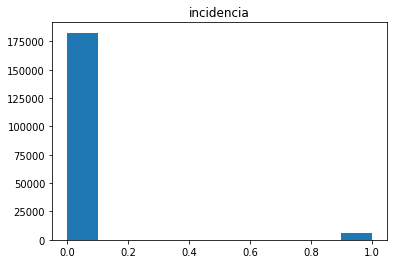

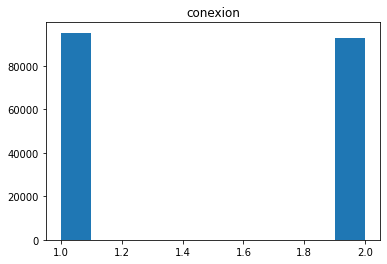

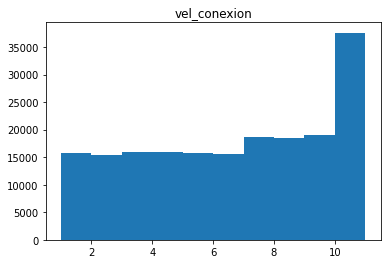

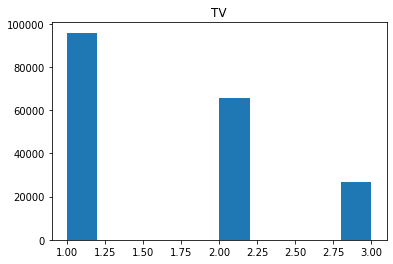

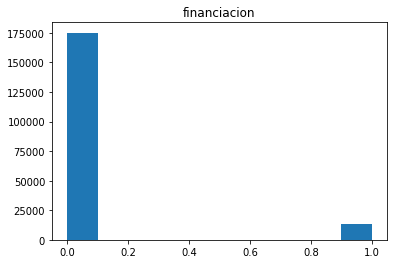

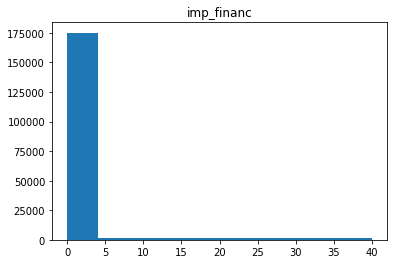

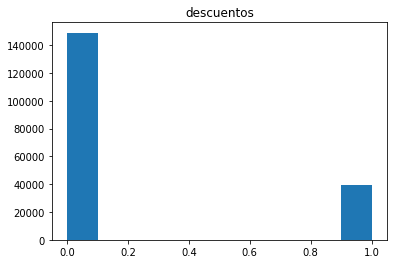

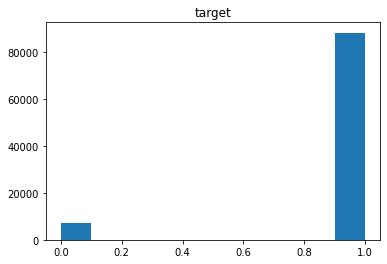

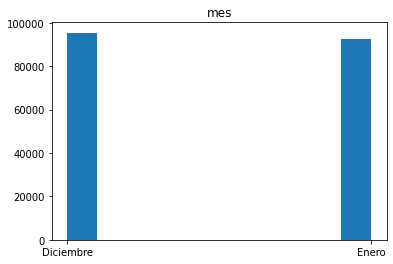

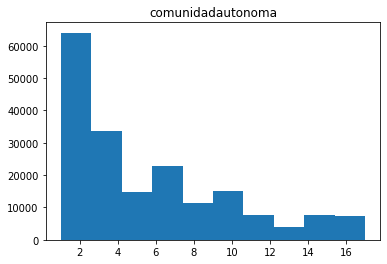

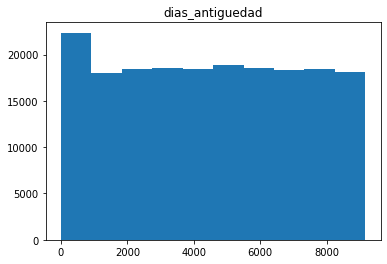

In [54]:
for l in total1:
    plt.hist(total1[l])
    plt.title(l)
    plt.show()

#### Dividimos nuestro dataset entre diciembre y enero para poder realizar nuestro primer modelo

In [55]:
dic = total1[total.mes == 'Diciembre']
ene = total1[total.mes == 'Enero']
dic.drop('mes', axis = 1, inplace = True)
ene.drop('mes', axis = 1, inplace = True)

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [56]:
X = dic.loc[:, dic.columns != 'target']
y = dic['target']

In [57]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = y)

In [58]:
def saca_metricas(y1, y2):
    print('matriz de confusión')
    print(confusion_matrix(y1, y2))
    print('accuracy')
    print(accuracy_score(y1, y2))
    print('precision')
    print(precision_score(y1, y2))
    print('recall')
    print(recall_score(y1, y2))
    print('f1')
    print(f1_score(y1, y2))
    false_positive_rate, recall, thresholds = roc_curve(y1, y2)
    roc_auc = auc(false_positive_rate, recall)
    print('AUC')
    print(roc_auc)
    plt.plot(false_positive_rate, recall, 'b')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('AUC = %0.2f' % roc_auc)

#### Realizamos nuestro primer modelo con RandomForest y XGBoost, ambos con n_estimators = 1000 para que trabajen igual.

matriz de confusión
[[  822   595]
 [   74 17603]]
accuracy
0.96496281554415
precision
0.9673040993515771
recall
0.9958137693047463
f1
0.9813519163763067
AUC
0.7879562847935163


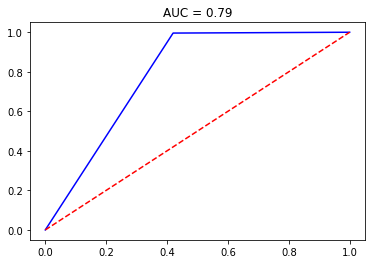

In [59]:
rf_model1 = RandomForestClassifier(n_estimators = 1000).fit(X_train, y_train)#max_depth = 10).fit(X_train, y_train)
y_pred_rf_model1 = rf_model1.predict(X_test)
saca_metricas(y_test, y_pred_rf_model1)

/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:51:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
matriz de confusión
[[  873   544]
 [  180 17497]]
accuracy
0.9620823295276003
precision
0.9698464608391996
recall
0.9898172766872206
f1
0.9797301080687608
AUC
0.8029538041869413


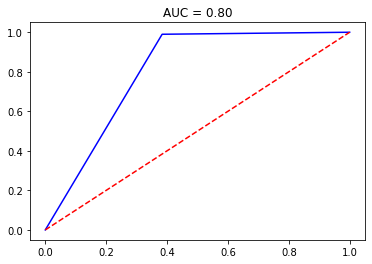

In [60]:
xgb_model1 = XGBClassifier(n_estimators = 1000).fit(X_train, y_train)
y_pred_xgb_model1 = xgb_model1.predict(X_test)
saca_metricas(y_test, y_pred_xgb_model1)

#### Observamos la importancia de cada variable con respecto a la target

In [61]:
corr = abs(total1.corr())
corr[['target']].sort_values(by = 'target',ascending = False).style.background_gradient()

,target
target,1.000000
num_dt,0.312795
edad,0.296835
incidencia,0.277408
TV,0.160122
descuentos,0.141447
financiacion,0.074597
imp_financ,0.067626
conexion,0.051478
num_llamad_ent,0.006130


### Ahora intentaremos mejorar nuestro modelo convirtiendo variables binarias, y TV, a dummies

In [62]:
total1.head()

,id,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,edad,facturacion,num_lineas,num_dt,...,conexion,vel_conexion,TV,financiacion,imp_financ,descuentos,target,mes,comunidadautonoma,dias_antiguedad
0,1,110,79,10897,12806,13751,63,216.028109,5,0.0,...,2,7,1,0,0.0,0,1.0,Diciembre,16,403
1,2,189,89,18657,6499,10862,84,255.830842,3,0.0,...,2,11,1,0,0.0,1,1.0,Diciembre,8,861
2,3,129,30,15511,17013,16743,66,135.768153,4,0.0,...,1,6,1,0,0.0,1,1.0,Diciembre,3,6578
3,4,51,52,12670,3393,6771,69,255.658527,4,0.0,...,2,9,2,0,0.0,0,1.0,Diciembre,4,1606
4,5,183,3,23756,18436,4485,30,22.302845,2,2.0,...,1,1,1,0,0.0,0,0.0,Diciembre,5,8159


In [63]:
total1['imp_financ'] = total1['imp_financ'].apply(lambda x: 0 if x<=0 else 1)

lista_binarias=['TV','financiacion','imp_financ','descuentos','conexion']
for k in lista_binarias:
    dummies = pd.get_dummies(total1[k],prefix=k)
    total1 = pd.concat([total1, dummies], axis=1)

#### Feature Engineering

In [64]:
def proporciones_final (var,target,df):

    proporcion = pd.DataFrame()
    
    proporcion['usuarios'] = df[target].groupby(df[var]).mean()*100
    proporcion['Conteo'] = df[target].groupby(df[var]).count()
    proporcion= proporcion.round(3)   
    proporcion_filtered = proporcion[(proporcion['usuarios']>0) & (proporcion['Conteo']>10)]
        
    if len(proporcion_filtered)<100 and len(proporcion_filtered)>1:
        fig = plt.figure()
        ax = proporcion_filtered['Conteo'].plot(kind='bar',grid=True)
                
        ax2 = ax.twinx()
        ax2.plot(proporcion_filtered['usuarios'].values, linestyle='-', linewidth=2.0,color='g')
        plt.tight_layout()        
    else:        
        proporcion_filtered.reset_index(inplace=True)
        sns.lmplot(x = var,y ='usuarios',data=proporcion_filtered, fit_reg=True,ci=None)    

/usr/local/lib/python3.9/site-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


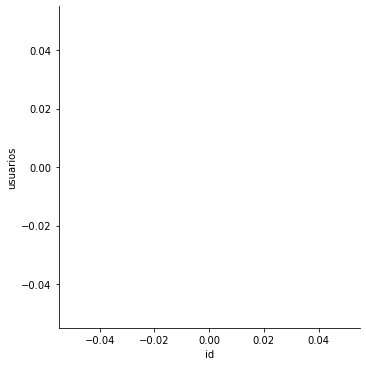

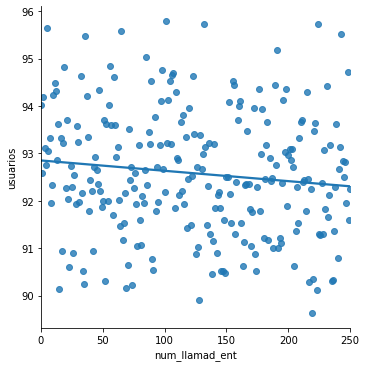

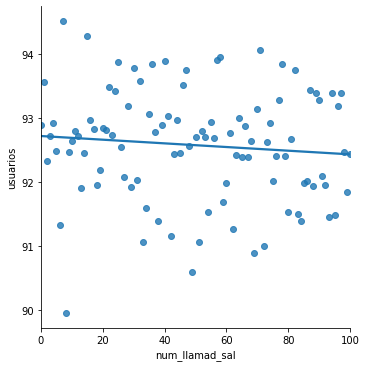

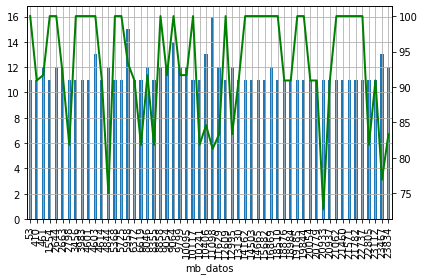

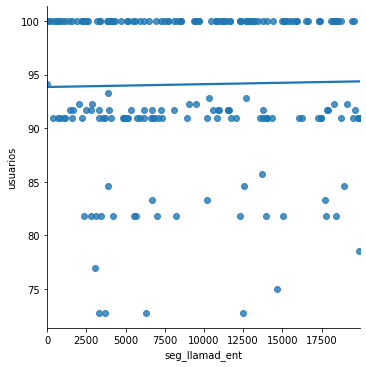

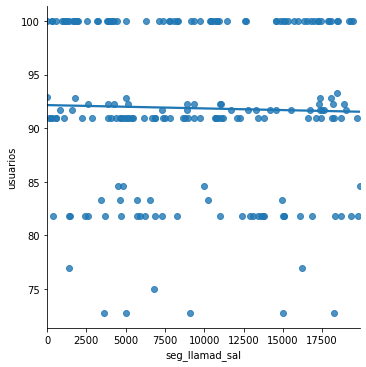

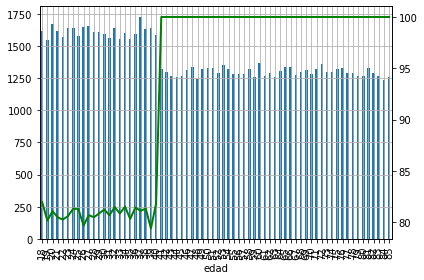

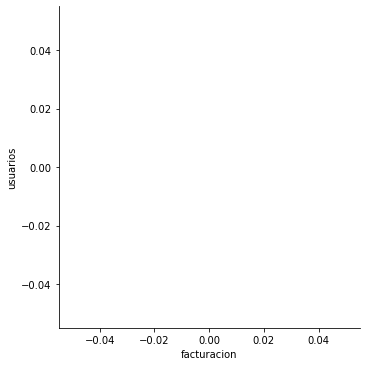

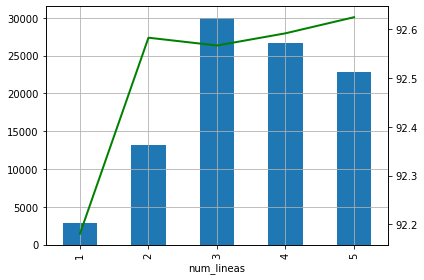

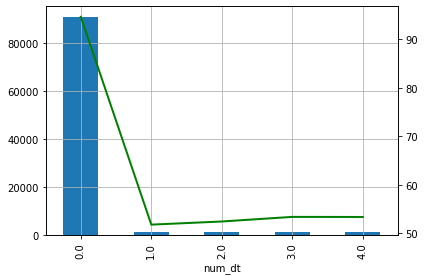

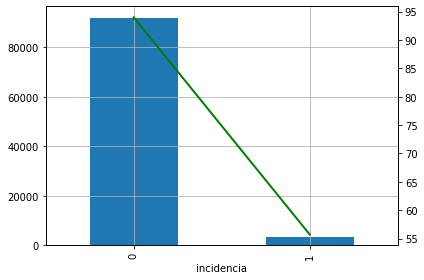

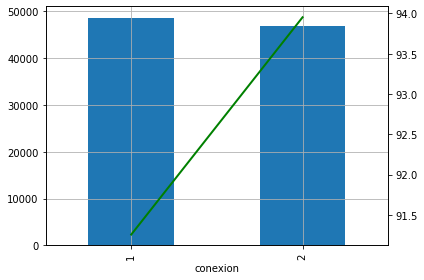

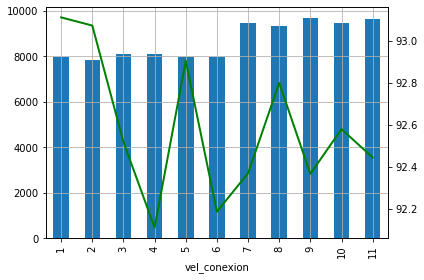

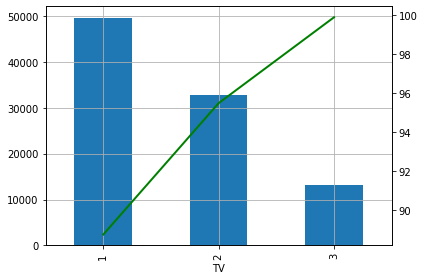

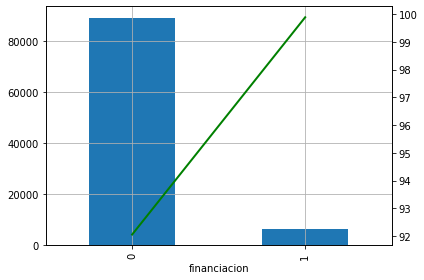

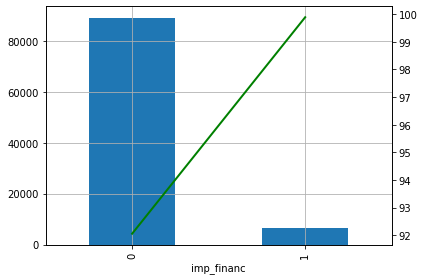

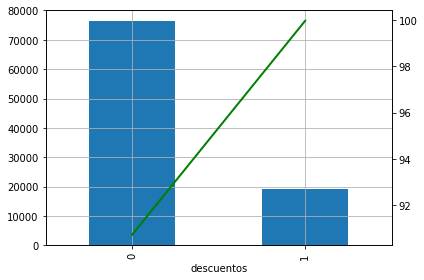

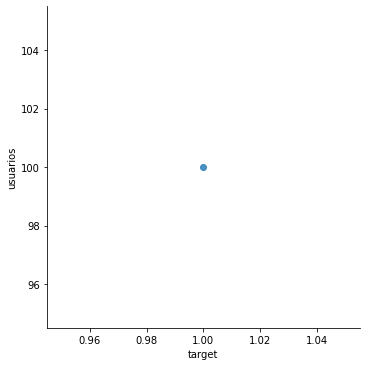

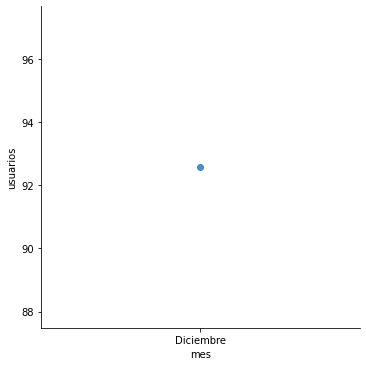

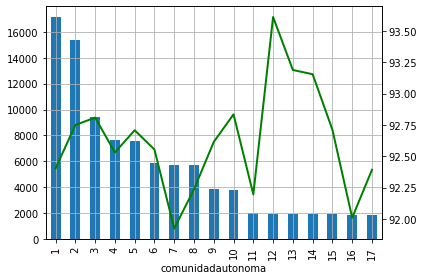

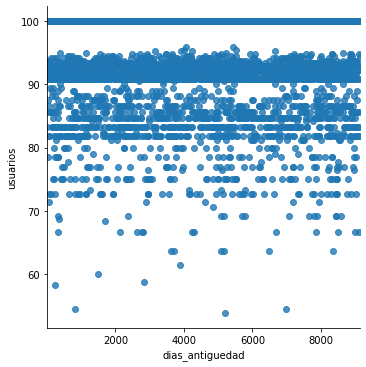

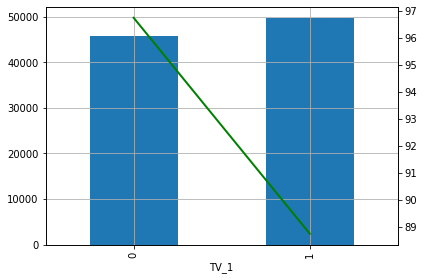

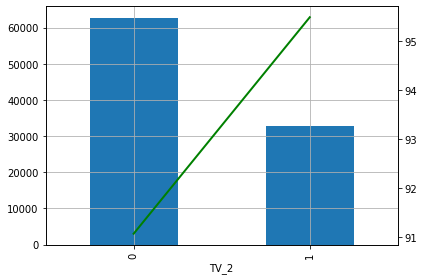

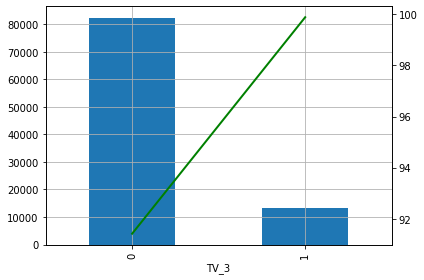

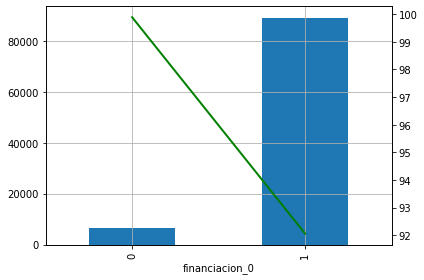

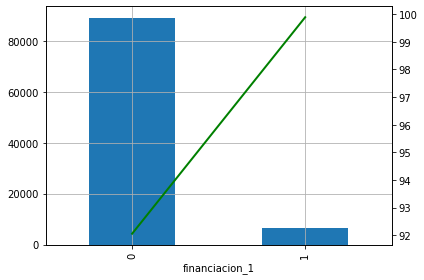

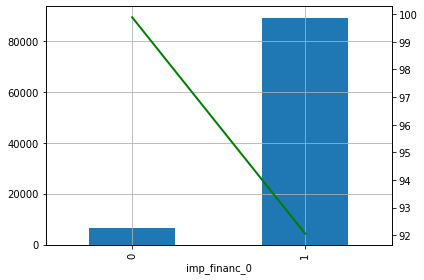

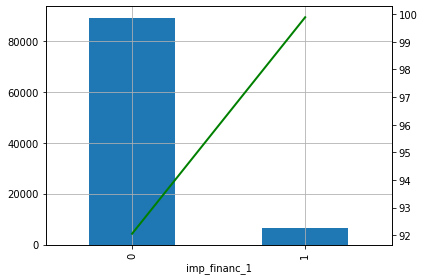

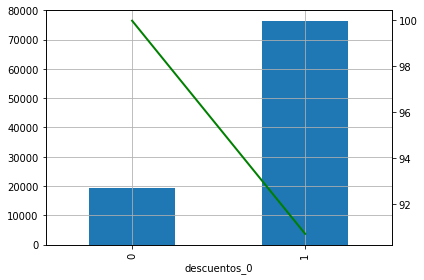

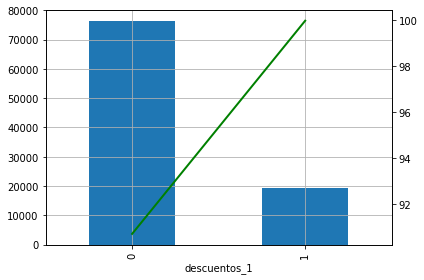

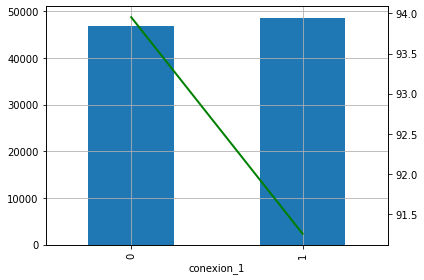

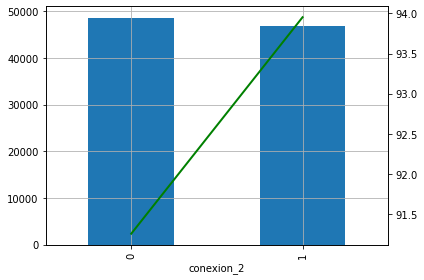

In [65]:
for i in total1.columns:
    proporciones_final (i, 'target', total1)

#### Tramificamos variables para intentar mejorar la relación de cada una de ellas con respecto a la variable target

In [66]:
def tramos(varib,varib_destino,tamanio,maximo,df):
    df[varib_destino]=np.where(df[varib]==0,-1,(df[varib]//tamanio)*tamanio)
    df[varib_destino]=np.where(df[varib_destino]>=maximo,maximo,df[varib_destino])

In [67]:
total1.imp_financ.unique()

array([0, 1])

In [68]:
total1.describe()

,id,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,edad,facturacion,num_lineas,num_dt,...,TV_2,TV_3,financiacion_0,financiacion_1,imp_financ_0,imp_financ_1,descuentos_0,descuentos_1,conexion_1,conexion_2
count,188178.000000,188178.000000,188178.000000,188178.000000,188178.000000,188178.000000,188178.000000,188178.000000,188178.000000,188178.000000,...,188178.000000,188178.000000,188178.000000,188178.000000,188178.000000,188178.000000,188178.000000,188178.000000,188178.000000,188178.000000
mean,49995.915575,124.960580,49.942060,12499.843850,9964.973217,9979.341969,50.592227,207.440105,3.559731,0.098168,...,0.348436,0.142339,0.930715,0.069285,0.930715,0.069285,0.791729,0.208271,0.506021,0.493979
std,28868.075573,72.457194,29.163648,7228.701809,5779.620186,5803.444024,19.728833,111.291972,1.090756,0.535241,...,0.476476,0.349398,0.253940,0.253940,0.253940,0.253940,0.406073,0.406073,0.499965,0.499965
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,15.000439,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,24980.000000,62.000000,25.000000,6205.000000,4956.000000,4959.000000,33.000000,111.370882,3.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,49985.000000,125.000000,50.000000,12496.000000,9959.000000,9980.000000,50.000000,206.927616,4.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,75005.750000,188.000000,75.000000,18764.000000,14965.000000,14998.000000,68.000000,304.388724,4.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,100000.000000,250.000000,100.000000,25000.000000,20000.000000,20000.000000,85.000000,399.998433,39.000000,4.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [69]:
total1.num_dt.value_counts()

0.0    180835
4.0      1891
3.0      1822
1.0      1817
2.0      1813
Name: num_dt, dtype: int64

In [70]:
# EDAD (Primero creo tramos en base a edades convenientes por el describe, y otra en base a su impacto con la target)
total1['edad_tramos'] = total1['edad'].apply(lambda x: 0 if x<= 33 else (1 if x<50 else(2 if x<68 else(3))))
total1['edad_tramos_nueva'] = total1['edad'].apply(lambda x: 0 if x<39 else 1)

# DIAS_ANTIGUEDAD (Ver el impacto de permanecer al menos 1 año)
total1['dias_antiguedad_tramos'] = total1['dias_antiguedad'].apply(lambda x: 0 if x<= 2160 else (1 if x<4500 else(2 if x<6810 else(3))))
total1['dias_antiguedad_nuevo'] =  total1['dias_antiguedad'].apply(lambda x: 0 if x<365 else 1)

# IMP_FINANC (0 si no tiene financiación y 1 si es lo contrario)
total1['imp_financ_tramos'] = total1['imp_financ'].apply(lambda x: 0 if x<1 else 1)

# Creo tramos para la variable llamadas en segundos, tanto para entrante como para saliente.
total1['seg_llamad_ent_tramos'] = total1['seg_llamad_ent'].apply(lambda x: 0 if x<= 5000 else (1 if x<10000 else(2)))
total1['seg_llamad_sal_tramos'] = total1['seg_llamad_sal'].apply(lambda x: 0 if x<= 3000 else (1 if x<7000 else(2)))

# NUM_DT_TRAMOS donde unifico en 1 si es mayor a 0.
total1['num_dt_tramos'] = total1['num_dt'].apply(lambda x: 0 if x<=0 else 1)

# Creo tramos para la cantidad de llamadas.
total1['num_llamad_ent_tramos'] = total1['num_llamad_ent'].apply(lambda x: 0 if x<= 20 else (1 if x<80 else(2 if x<160 else(3))))
total1['num_llamad_sal_tramos'] = total1['num_llamad_sal'].apply(lambda x: 0 if x<= 30 else (1 if x<80 else(2)))

total1['facturacion_tramos'] = total1['facturacion'].apply(lambda x: 0 if x<= 60 else (1 if x<140 else(2)))

total1['mb_datos_tramos'] = total1['mb_datos'].apply(lambda x: 0 if x<= 8000 else (1 if x<15000 else(2)))

# Creo NUM_DT_TRAMOS de manera de unificar las que tengan menos de 2 y agrupar de manera más uniforme.
total1['num_lineas_tramos'] = total1['num_lineas'].replace({'1':'2','18':'2','26':'2','39':'2'})

#### Voy a intentar crear un nuevo modelo tomando en cuenta todos los tramos a ver como ha ido lo que he hecho

In [71]:
dic = total1[total.mes == 'Diciembre']
ene = total1[total.mes == 'Enero']
dic.drop('mes', axis = 1, inplace = True)
ene.drop('mes', axis = 1, inplace = True)

X = dic.loc[:, dic.columns != 'target']
y = dic['target']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = y)

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


matriz de confusión
[[  819   598]
 [   75 17602]]
accuracy
0.9647533256520373
precision
0.9671428571428572
recall
0.9957571986196753
f1
0.9812414638905148
AUC
0.786869424997911


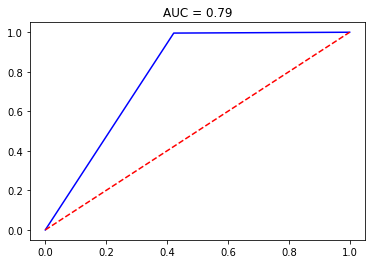

In [72]:
rf_model2 = RandomForestClassifier(n_estimators = 1000).fit(X_train, y_train)#max_depth = 10).fit(X_train, y_train)
y_pred_rf_model2 = rf_model2.predict(X_test)
saca_metricas(y_test, y_pred_rf_model2)

/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:54:41] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
matriz de confusión
[[  861   556]
 [  167 17510]]
accuracy
0.9621347020006285
precision
0.9692239566035648
recall
0.9905526955931436
f1
0.9797722631004673
AUC
0.7990872158276233


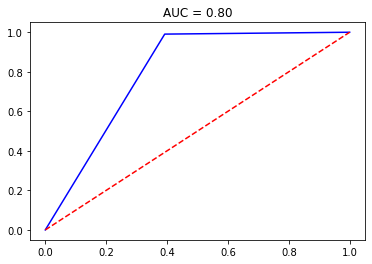

In [73]:
xgb_model2 = XGBClassifier(n_estimators = 1000).fit(X_train, y_train)
y_pred_xgb_model2 = xgb_model2.predict(X_test)
saca_metricas(y_test, y_pred_xgb_model2)

In [74]:
corr2 = abs(total1.corr())
corr2[['target']].sort_values(by = 'target',ascending = False).style.background_gradient()

,target
target,1.000000
num_dt_tramos,0.346618
edad_tramos_nueva,0.329846
num_dt,0.312795
edad,0.296835
edad_tramos,0.290942
incidencia,0.277408
TV,0.160122
TV_1,0.152493
descuentos_0,0.141447


In [75]:
X.shape

(95467, 43)

#### Visto el resultado, voy a realizar una selección de variables a ver si lo mejoro.

In [76]:
S_chi2 = SelectKBest(chi2, k = 20)
X_chi2 = S_chi2.fit_transform(X, y)

variables = list(np.asarray(list(X))[S_chi2.get_support()])
variables.sort()
print(variables)

['TV', 'TV_1', 'TV_2', 'TV_3', 'descuentos', 'descuentos_1', 'dias_antiguedad', 'edad', 'edad_tramos', 'edad_tramos_nueva', 'financiacion', 'financiacion_1', 'id', 'imp_financ', 'imp_financ_1', 'imp_financ_tramos', 'incidencia', 'mb_datos', 'num_dt', 'num_dt_tramos']


In [77]:
Xcolumnas = ['TV_1', 'TV_2', 'TV_3', 'descuentos', 'descuentos_1', 'dias_antiguedad', 'edad',
             'edad_tramos', 'edad_tramos_nueva', 'financiacion', 'financiacion_1', 'id', 'imp_financ',
             'imp_financ_1', 'imp_financ_tramos', 'incidencia', 'mb_datos', 'num_dt', 'num_dt_tramos']

In [78]:
X = X[Xcolumnas]

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = y)

matriz de confusión
[[  799   618]
 [  151 17526]]
accuracy
0.9597255682413324
precision
0.9659391534391535
recall
0.9914578265542796
f1
0.9785321459479077
AUC
0.7776625759447475


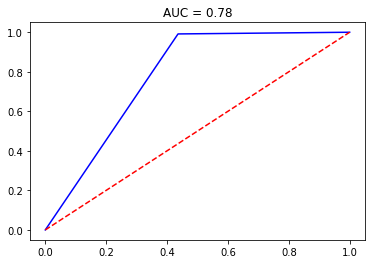

In [80]:
rf_model3 = RandomForestClassifier(n_estimators = 1000).fit(X_train, y_train)#max_depth = 10).fit(X_train, y_train)
y_pred_rf_model3 = rf_model3.predict(X_test)
saca_metricas(y_test, y_pred_rf_model3)

/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:05:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
matriz de confusión
[[  830   587]
 [  224 17453]]
accuracy
0.957525924374149
precision
0.9674611973392461
recall
0.9873281665440968
f1
0.9772937256768485
AUC
0.7865363486213779


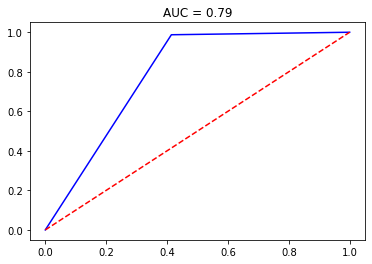

In [81]:
xgb_model3 = XGBClassifier(n_estimators = 1000).fit(X_train, y_train)
y_pred_xgb_model3 = xgb_model3.predict(X_test)
saca_metricas(y_test, y_pred_xgb_model3)

#### Veo que el resultado no mejora, voy a intentar con otros algoritmos.

In [82]:
dic = total1[total.mes == 'Diciembre']
ene = total1[total.mes == 'Enero']
dic.drop('mes', axis = 1, inplace = True)
ene.drop('mes', axis = 1, inplace = True)

X = dic.loc[:, dic.columns != 'target']
y = dic['target']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = y)

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


#### Al ejecutar el código anterior me genera la gráfica que adjunto a continuación, el problema es que luego de ejecutar el código todas las gráficas que intentaba obtener me generaban un error a la hora de trazar la roc curve, dando como error esto "TypeError: 'numpy.float64' object is not callable". Por lo tanto le tome un print y voy a volver a ejecutar todo el código saltándome estas líneas.

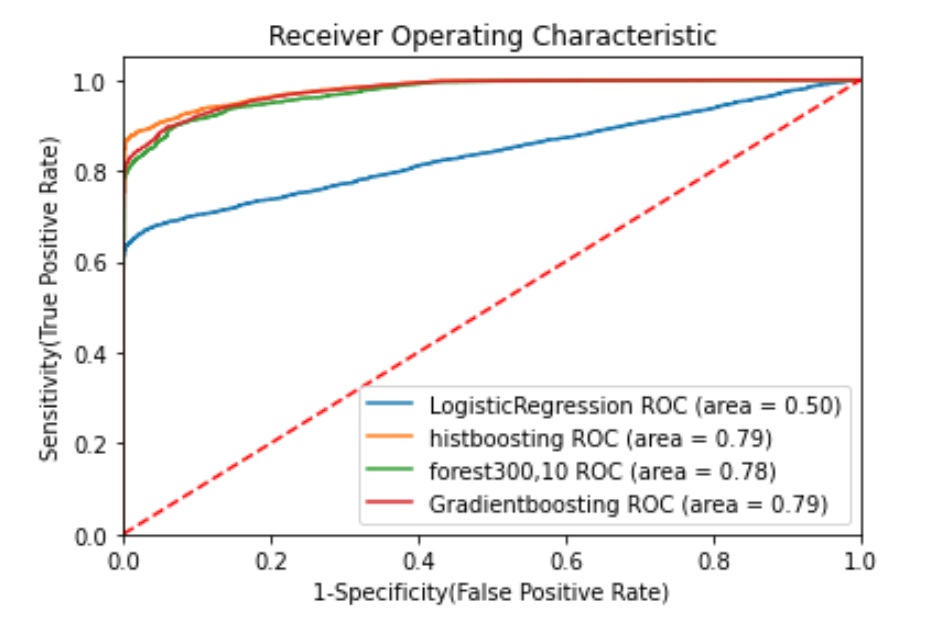

#### Veo como aún así no termino de mejorar los dos primeros modelos que obtuve, y que el mejor que me ha dado es XGBoost. Pienso que quizás puedo tramear mejor de manera de obtener mejores resultados, o seleccionar menos variables y que al final logrando una roc curve similar a los primeros modelos podría ser mejor a la hora de explicar resultados a una junta directiva.

#### Lo pruebo ahora con el ejemplo de la página de Chris Albon.

In [83]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([('classifier', RandomForestClassifier())])

search_space = [{'classifier': [LogisticRegression()],
                 'classifier__penalty': ['l1', 'l2'],
                 'classifier__C': np.logspace(4, 10)},
                {'classifier': [RandomForestClassifier()],
                 'classifier__n_estimators': [100, 1000],
                 'classifier__max_features': [2, 3]}]

In [84]:
# Create grid search 
clf = GridSearchCV(pipe, search_space, cv=5, verbose=0)

In [85]:
# Fit grid search
best_model = clf.fit(X_train, y_train)

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1407, in fit
    fold_coefs_ = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.9/site-packages/joblib/parallel.py", line 859, in dispatch_one_batch
    self._dispatch(tasks)
  File "/u

In [86]:
# View best model
best_model.best_estimator_.get_params()['classifier']

RandomForestClassifier(max_features=3, n_estimators=1000)

In [87]:
rf_model4 = RandomForestClassifier(max_features=3, n_estimators=1000).fit(X_train, y_train)
y_pred_rf_model4    = rf_model4.predict(X_test)

matriz de confusión
[[  810   607]
 [   72 17605]]
accuracy
0.9644390908138682
precision
0.9666703272567538
recall
0.9959269106748883
f1
0.9810805539301736
AUC
0.7837785576663079


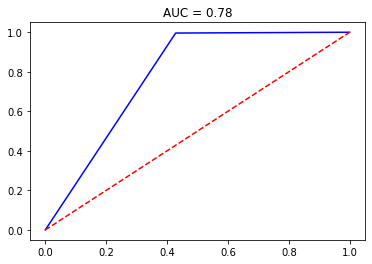

In [88]:
saca_metricas(y_test, y_pred_rf_model4)

#### Hago grid search únicamente a random forest probando el código de la clase

In [89]:
grid_param = {
    'n_estimators': [100, 600, 1000],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
    'max_depth': [4,10,16]
}

In [90]:
model_grid = GridSearchCV(estimator=rf_model2,
                     param_grid=grid_param,
                     scoring='recall',
                     cv=5,
                     n_jobs=-1)

In [91]:
model_grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_estimators=1000),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 10, 16],
                         'n_estimators': [100, 600, 1000]},
             scoring='recall')

In [92]:
print(model_grid.best_params_)

{'bootstrap': True, 'criterion': 'gini', 'max_depth': 4, 'n_estimators': 100}


In [93]:
print(model_grid.best_score_)

0.9974824977017185


In [94]:
rf_model5 = RandomForestClassifier(bootstrap = True, criterion = 'entropy', max_depth = 4, n_estimators = 10).fit(X_train, y_train)
y_pred_rf_model5    = rf_model5.predict(X_test)

matriz de confusión
[[  382  1035]
 [   32 17645]]
accuracy
0.9441185712789358
precision
0.944593147751606
recall
0.9981897380777282
f1
0.970652144016283
AUC
0.6338866827297603


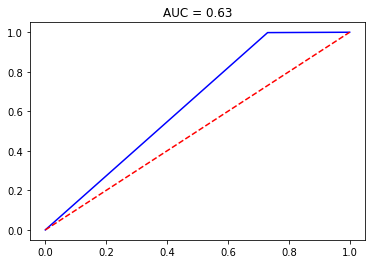

In [95]:
saca_metricas(y_test, y_pred_rf_model5)

In [96]:
print(classification_report(y_test, y_pred_rf_model5))

              precision    recall  f1-score   support

         0.0       0.92      0.27      0.42      1417
         1.0       0.94      1.00      0.97     17677

    accuracy                           0.94     19094
   macro avg       0.93      0.63      0.69     19094
weighted avg       0.94      0.94      0.93     19094



#### Balanceo datos.
#### Ya que indistintamente lo que haga no consigo mejorar el modelo, intentaré hacer un balanceo de datos y luego ejecutar alguno de los códigos anteriormente realizados a ver si mejora con ello. Pienso que lo importante es aprender de todo un poco sobre lo que vimos en clase.

In [97]:
print("Before OverSampling, counts of label '1': {}".format(sum(y==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y==0)))

sm = SMOTE(random_state=2)
X_res, y_res = sm.fit_resample(X, y.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train==0)))

Before OverSampling, counts of label '1': 88382
Before OverSampling, counts of label '0': 7085 

After OverSampling, the shape of train_X: (76373, 43)
After OverSampling, the shape of train_y: (76373,) 

After OverSampling, counts of label '1': 70705
After OverSampling, counts of label '0': 5668


In [98]:
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(X_res,
                                                    y_res,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify = y_res)

In [99]:
rf_model6 = LogisticRegression(solver ="liblinear" ,max_iter=1000, class_weight="balanced").fit(X_train_res, y_train_res)
y_pred_rf_model6     = rf_model6.predict(X_test) 

matriz de confusión
[[  977   440]
 [ 1018 16659]]
accuracy
0.9236409343249188
precision
0.9742675010234516
recall
0.9424110425977259
f1
0.9580745341614907
AUC
0.8159479348486159


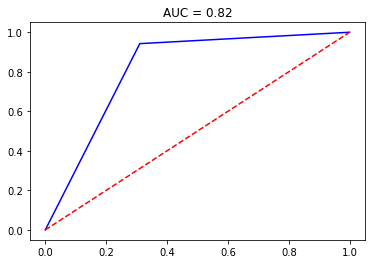

In [100]:
saca_metricas(y_test, y_pred_rf_model6)

In [101]:
grid_param = {
    'max_iter': [100, 1000],
    'penalty': ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
}

In [102]:
model_grid = GridSearchCV(estimator=rf_model6,
                     param_grid=grid_param,
                     scoring='accuracy',
                     cv=5,
                     n_jobs=-1)

#### Como aspectos a destacar y a mejorar por mi parte, me apunto mejorar los tramos y las variables nuevas creadas, siento que se me quedo corto.

#### Con respecto a los modelos trabajados, el Xgboost siempre fue el que mejor resultado me dió, aunque todos fueron realmente similares, luego gracias al balanceo de la target pude obtener un 0.82 con el logistic regression, y por lo que he investigado este modelo es más sencillo a la hora de explicar los resultados obtenidos, así que estoy satisfecho con ese incremento logrado. 

In [108]:
results = cross_val_score(estimator=rf_model6, X=X_train_res, y=y_train_res, cv=5)

In [109]:
results

array([0.94657568, 0.94459373, 0.94848313, 0.95039248, 0.94926101])

In [110]:
print(results.mean())

0.947861208007344


In [111]:
print(results.std())

0.0020534131094154676


In [118]:
ene.head()

,id,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,edad,facturacion,num_lineas,num_dt,...,dias_antiguedad_nuevo,imp_financ_tramos,seg_llamad_ent_tramos,seg_llamad_sal_tramos,num_dt_tramos,num_llamad_ent_tramos,num_llamad_sal_tramos,facturacion_tramos,mb_datos_tramos,num_lineas_tramos
95467,1,95,19,6525,7634,18520,63,216.028109,5,0.0,...,1,0,1,2,0,2,0,2,0,5
95468,2,44,36,14471,14541,8016,84,255.830842,3,0.0,...,1,0,2,2,0,1,1,2,1,3
95469,3,94,27,1428,5248,7106,66,135.768153,4,0.0,...,1,0,1,2,0,2,0,1,0,4
95470,4,186,20,20083,7372,5052,69,255.658527,4,0.0,...,1,0,1,1,0,3,0,2,2,4
95471,6,37,32,19078,5009,8686,51,99.348645,4,0.0,...,1,0,1,2,0,1,1,1,2,4


In [122]:
ene.isnull().sum()

id                            0
num_llamad_ent                0
num_llamad_sal                0
mb_datos                      0
seg_llamad_ent                0
seg_llamad_sal                0
edad                          0
facturacion                   0
num_lineas                    0
num_dt                        0
incidencia                    0
conexion                      0
vel_conexion                  0
TV                            0
financiacion                  0
imp_financ                    0
descuentos                    0
target                    92711
comunidadautonoma             0
dias_antiguedad               0
TV_1                          0
TV_2                          0
TV_3                          0
financiacion_0                0
financiacion_1                0
imp_financ_0                  0
imp_financ_1                  0
descuentos_0                  0
descuentos_1                  0
conexion_1                    0
conexion_2                    0
edad_tra

In [123]:
targetEnero = ene.target

In [124]:
ene.drop('target', inplace=True, axis=1)

/usr/local/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Aplico mi mejor modelo para generar las probabilidades de una posible marcha de clientes

In [126]:
modelo_proba = rf_model6.predict_proba(ene)[:,1]

In [127]:
modelo_proba

array([0.99758139, 0.99999957, 0.99999427, ..., 0.4487648 , 0.99645398,
       0.99990447])

In [128]:
modelo_proba = (pd.DataFrame(modelo_proba,columns=['probabilidad'],index=ene.index))
modelo_proba.sort_values(by=['probabilidad'],ascending=False,axis=0,inplace=True)

In [129]:
ene.reset_index(inplace=True)

In [130]:
ene.shape

(92711, 44)

In [131]:
ene.head()

,index,id,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,edad,facturacion,num_lineas,...,dias_antiguedad_nuevo,imp_financ_tramos,seg_llamad_ent_tramos,seg_llamad_sal_tramos,num_dt_tramos,num_llamad_ent_tramos,num_llamad_sal_tramos,facturacion_tramos,mb_datos_tramos,num_lineas_tramos
0,95467,1,95,19,6525,7634,18520,63,216.028109,5,...,1,0,1,2,0,2,0,2,0,5
1,95468,2,44,36,14471,14541,8016,84,255.830842,3,...,1,0,2,2,0,1,1,2,1,3
2,95469,3,94,27,1428,5248,7106,66,135.768153,4,...,1,0,1,2,0,2,0,1,0,4
3,95470,4,186,20,20083,7372,5052,69,255.658527,4,...,1,0,1,1,0,3,0,2,2,4
4,95471,6,37,32,19078,5009,8686,51,99.348645,4,...,1,0,1,2,0,1,1,1,2,4


In [132]:
modelo_proba.reset_index(inplace=True)

In [138]:
modelo_proba.head()

,index,probabilidad
0,175380,1.0
1,162103,1.0
2,130752,1.0
3,148675,1.0
4,132809,1.0


In [134]:
results = pd.merge(ene, modelo_proba, on= ['index'])

In [135]:
results.sort_values(by='probabilidad', ascending= False)

,index,id,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,edad,facturacion,num_lineas,...,imp_financ_tramos,seg_llamad_ent_tramos,seg_llamad_sal_tramos,num_dt_tramos,num_llamad_ent_tramos,num_llamad_sal_tramos,facturacion_tramos,mb_datos_tramos,num_lineas_tramos,probabilidad
79913,175380,86158,85,82,8312,10901,18662,80,352.599973,3,...,1,2,2,0,2,2,2,1,3,1.000000
66636,162103,71906,92,69,5273,18520,5659,71,313.609698,5,...,1,2,1,0,2,1,2,0,5,1.000000
35285,130752,38024,80,45,8869,7072,18950,72,372.414311,4,...,1,1,2,0,2,1,2,1,4,1.000000
53208,148675,57415,47,31,3118,10827,10452,69,336.738328,3,...,1,2,2,0,1,1,2,0,3,1.000000
37342,132809,40259,92,86,22963,13094,7530,78,320.604399,5,...,1,2,2,0,2,2,2,2,5,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43372,138839,46790,218,10,18444,8816,8394,26,175.501132,2,...,0,1,2,1,3,0,2,2,2,0.000131
33406,128873,36006,35,56,24410,9144,6817,18,393.009352,3,...,0,1,1,1,1,1,2,2,3,0.000066
22547,118014,24282,170,78,24286,2871,12054,23,205.590546,3,...,0,0,2,1,3,1,2,2,3,0.000054
53493,148960,57715,232,7,12048,1317,14411,35,273.061792,3,...,0,0,2,1,3,0,2,1,3,0.000054


### Observamos los datos de los clientes que tienen baja probabilidad de continuar en la compañía. Establezco el límite en un 30%.

In [141]:
llamar = results[results.probabilidad < 0.30]

In [143]:
llamar.shape

(2630, 45)

In [144]:
ene.shape

(92711, 44)

In [152]:
porcentaje = (llamar.shape[0]/ene.shape[0])*100

print("El porcentaje de clientes con más del 70% de probabilidades de dejar la empresa es de {}%".format(round(porcentaje,1)))

El porcentaje de clientes con más del 70% de probabilidades de dejar la empresa es de 2.8%


In [142]:
llamar.head()

,index,id,num_llamad_ent,num_llamad_sal,mb_datos,seg_llamad_ent,seg_llamad_sal,edad,facturacion,num_lineas,...,imp_financ_tramos,seg_llamad_ent_tramos,seg_llamad_sal_tramos,num_dt_tramos,num_llamad_ent_tramos,num_llamad_sal_tramos,facturacion_tramos,mb_datos_tramos,num_lineas_tramos,probabilidad
45,95512,50,58,52,13013,4766,594,26,326.562050,3,...,0,0,0,0,1,1,2,1,3,0.293596
49,95516,55,204,79,2177,18817,16239,22,264.810725,4,...,0,2,2,0,3,1,2,0,4,0.196444
66,95533,74,12,25,24601,15939,14418,20,33.737013,1,...,0,2,2,0,0,0,0,2,1,0.225668
82,95549,91,144,27,10567,17048,19291,32,208.685021,4,...,0,2,2,0,2,0,2,1,4,0.269954
99,95566,109,59,18,7099,4876,17396,23,71.969521,3,...,0,0,2,0,1,0,1,0,3,0.117532


In [153]:
llamar.dtypes

index                       int64
id                          int64
num_llamad_ent              int64
num_llamad_sal              int64
mb_datos                    int64
seg_llamad_ent              int64
seg_llamad_sal              int64
edad                        int64
facturacion               float64
num_lineas                  int64
num_dt                    float64
incidencia                  int64
conexion                    int64
vel_conexion                int64
TV                          int64
financiacion                int64
imp_financ                  int64
descuentos                  int64
comunidadautonoma           int64
dias_antiguedad             int64
TV_1                        uint8
TV_2                        uint8
TV_3                        uint8
financiacion_0              uint8
financiacion_1              uint8
imp_financ_0                uint8
imp_financ_1                uint8
descuentos_0                uint8
descuentos_1                uint8
conexion_1    

In [166]:
df1 = llamar[["TV_1","TV_2","TV_3","financiacion_0","financiacion_1","imp_financ_0","imp_financ_1","descuentos_0",
              "descuentos_1","conexion_1","conexion_2","edad_tramos","edad_tramos_nueva","dias_antiguedad_tramos",
             "incidencia","num_dt"]]

In [167]:
df1.head()

,TV_1,TV_2,TV_3,financiacion_0,financiacion_1,imp_financ_0,imp_financ_1,descuentos_0,descuentos_1,conexion_1,conexion_2,edad_tramos,edad_tramos_nueva,dias_antiguedad_tramos,incidencia,num_dt
45,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0.0
49,1,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0.0
66,0,1,0,1,0,1,0,1,0,0,1,0,0,3,0,0.0
82,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0.0
99,1,0,0,1,0,1,0,1,0,1,0,0,0,2,0,0.0


In [159]:
df1.TV_1.value_counts(normalize=True)

1    0.929278
0    0.070722
Name: TV_1, dtype: float64

In [163]:
df1.edad_tramos_nueva.value_counts(normalize=True)

0    0.959316
1    0.040684
Name: edad_tramos_nueva, dtype: float64

In [164]:
df1.incidencia.value_counts(normalize=True)

0    0.936502
1    0.063498
Name: incidencia, dtype: float64

In [165]:
df1.financiacion_0.value_counts(normalize=True)

1    0.998859
0    0.001141
Name: financiacion_0, dtype: float64

In [168]:
df1.num_dt.value_counts(normalize=True)

0.0    0.874144
4.0    0.051331
3.0    0.031939
2.0    0.030038
1.0    0.012548
Name: num_dt, dtype: float64

# Conclusión:

Los clientes que tienen más de un 70% de probabilidad de marcharse de la compañía son los que cumplen las siguientes características:
 - El 95.9% tienen menos de 40 años.
 - El 93.6% no tienen incidencia o reclamación.
 - El 99.8% no tienen ningún tipo de financiación o descuento.
 - El 92.9% tienen contratado el paquete de tv-futbol.
 - El 87.4% no tienen ninguna linea en impago.

Por tanto, la campaña que tendría que lanzar esta compañía es hacia clientes menores de 40 años, que sean buenos clientes (líneas sin impago), que no esten financiados o con descuentos por parte de la empresa y que tengan contratado el paquete de fútbol.

También me gustaría comentar que en base a la campaña que se quiera realizar los % se podrían ajustar, así como verificar alguna variable en concreto como verifiqué las anteriores, por poner ejemplo.